In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

res = 1  # 1 km resolution
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new, indexing='ij')
new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

interp_lon = RegularGridInterpolator((x_grid, y_grid), lon_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)
interp_lat = RegularGridInterpolator((x_grid, y_grid), lat_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)

lon_new = interp_lon(new_points).reshape(len(x_new), len(y_new))
lat_new = interp_lat(new_points).reshape(len(x_new), len(y_new))

In [2]:
df_eddies_true = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_1462_10650.pkl")
df_eddies_true


,Eddy,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,x0,y0,q11,q12,q22,w,ID,next_num
0,0,1462,AE,160.569072,-28.075269,830.0,1515.0,830,1515,836.867917,1520.899658,0.003011,-0.000090,0.005076,0.016174,0,80179
1,1,1462,AE,155.725082,-27.535036,358.0,1408.0,358,1408,357.723030,1404.524061,0.007987,-0.002294,0.005803,0.027581,1,80179
2,2,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,2,80179
3,3,1462,CE,156.973832,-28.452969,506.0,1354.0,506,1354,510.292455,1353.033146,-0.008094,0.001176,-0.006943,-0.030074,3,80179
4,4,1462,AE,159.170505,-29.807511,754.0,1285.0,754,1285,752.203674,1287.290040,0.005505,-0.001515,0.003850,0.018711,4,80179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412607,24,10650,AE,151.460338,-38.218269,349.0,158.0,349,158,347.972729,164.451434,0.008346,0.000024,0.004795,0.026282,79959,80179
412608,25,10650,CE,158.194230,-40.416548,973.0,126.0,973,126,975.638390,122.704594,-0.000453,0.000232,-0.001166,-0.003239,80161,80179
412609,26,10650,AE,156.242892,-40.165033,805.0,95.0,805,95,803.196837,96.977325,0.002822,0.000897,0.002131,0.009906,80113,80179
412610,27,10650,CE,148.933514,-38.691752,157.0,34.0,157,34,143.141637,36.258489,-0.001199,-0.000704,-0.001818,-0.006034,79900,80179


In [3]:
df_eddies = df_eddies_true.sort_values(by=['ID', 'Day']).drop('Eddy', axis=1).drop('next_num', axis=1).copy()
df_eddies = df_eddies[df_eddies.groupby('ID')['ID'].transform('count') >= 21] # 3 Weeks
df_eddies['ID'] = df_eddies['ID'].rank(method='dense').astype(int)
df_eddies = df_eddies[['ID'] + [col for col in df_eddies.columns if col != 'ID']]
# Find Lon and Lat values
xg, yg = X_new.T[0, :], Y_new.T[:, 0] 
lon_interp = RegularGridInterpolator((yg, xg), lon_new.T, bounds_error=False, fill_value=np.nan)
lat_interp = RegularGridInterpolator((yg, xg), lat_new.T, bounds_error=False, fill_value=np.nan)
points = np.column_stack((df_eddies['y0'], df_eddies['x0']))
lon_vals, lat_vals = lon_interp(points), lat_interp(points)
df_eddies['Lon'], df_eddies['Lat'] = lon_vals, lat_vals
cols = list(df_eddies.columns)
njc_idx = cols.index('njc')
new_order = cols[:njc_idx + 1] + ['Lon', 'Lat'] + [col for col in cols if col not in ['Lon', 'Lat'] and col not in cols[:njc_idx + 1]]
df_eddies = df_eddies[new_order]
df_eddies = df_eddies.reset_index(drop=True)
df_eddies


,ID,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,Lon,Lat,x0,y0,q11,q12,q22,w
0,1,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,161.093546,-29.714998,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293
1,1,1463,CE,160.817916,-29.751246,905.0,1346.0,905,1346,160.871720,-29.764770,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868
2,1,1464,CE,160.891777,-29.755719,912.0,1348.0,912,1348,160.922307,-29.791470,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804
3,1,1465,CE,160.926573,-29.615816,911.0,1364.0,911,1364,160.955011,-29.644446,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635
4,1,1466,CE,160.902923,-29.589467,908.0,1366.0,908,1366,160.900960,-29.634113,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117851,2962,10646,CE,155.138848,-40.093169,712.0,70.0,712,70,155.090978,-40.102161,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201
117852,2962,10647,CE,154.887561,-40.391305,700.0,31.0,700,31,154.836115,-40.385267,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245
117853,2962,10648,CE,155.024247,-40.523479,715.0,21.0,715,21,154.979715,-40.569836,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006
117854,2962,10649,CE,155.192478,-40.287251,722.0,51.0,722,51,155.150873,-40.263961,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783


In [4]:
def interpolate_eddy_tracks(df):
    df = df.copy()
    df_interp = []

    for eddy_id, group in df.groupby('ID'):
        # Build a full range of days for this eddy
        full_days = pd.DataFrame({'Day': range(group['Day'].min(), group['Day'].max() + 1)})
        full_days['ID'] = eddy_id

        # Merge to reindex with all days, keeping columns of interest
        merged = pd.merge(full_days, group, on=['ID', 'Day'], how='left')

        # Interpolate numerical columns
        merged['Lon'] = merged['Lon'].interpolate()
        merged['Lat'] = merged['Lat'].interpolate()
        merged['x0'] = merged['x0'].interpolate()
        merged['y0'] = merged['y0'].interpolate()

        # Fill categorical column
        merged['Cyc'] = merged['Cyc'].ffill().bfill()

        df_interp.append(merged)

    df_result = pd.concat(df_interp, ignore_index=True).sort_values(by=['ID', 'Day'])

    return df_result
df_eddies = interpolate_eddy_tracks(df_eddies)
df_eddies['Age'] = df_eddies.groupby('ID')['ID'].transform('count')
fnames = [
    f"/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{1461 + ((day - 1462) // 30) * 30:05}.nc"
    for day in df_eddies['Day']
]
df_eddies['fname'] = fnames
df_eddies

,Day,ID,Cyc,nLon,nLat,nxc,nyc,nic,njc,Lon,Lat,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.070068,-29.736625,928.0,1356.0,928.0,1356.0,161.093546,-29.714998,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.817916,-29.751246,905.0,1346.0,905.0,1346.0,160.871720,-29.764770,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.891777,-29.755719,912.0,1348.0,912.0,1348.0,160.922307,-29.791470,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.926573,-29.615816,911.0,1364.0,911.0,1364.0,160.955011,-29.644446,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.902923,-29.589467,908.0,1366.0,908.0,1366.0,160.900960,-29.634113,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132634,10646,2962,CE,155.138848,-40.093169,712.0,70.0,712.0,70.0,155.090978,-40.102161,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132635,10647,2962,CE,154.887561,-40.391305,700.0,31.0,700.0,31.0,154.836115,-40.385267,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132636,10648,2962,CE,155.024247,-40.523479,715.0,21.0,715.0,21.0,154.979715,-40.569836,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132637,10649,2962,CE,155.192478,-40.287251,722.0,51.0,722.0,51.0,155.150873,-40.263961,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [5]:
df_eddies.to_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


In [6]:
duplicates = df_eddies[df_eddies.duplicated(subset=['ID', 'Day'], keep=False)]
duplicates

,Day,ID,Cyc,nLon,nLat,nxc,nyc,nic,njc,Lon,Lat,x0,y0,q11,q12,q22,w,Age,fname


(np.float64(7.359095973834592),
 np.float64(1045.2497596421324),
 np.float64(-110.66291419930491),
 np.float64(1655.999221024783))

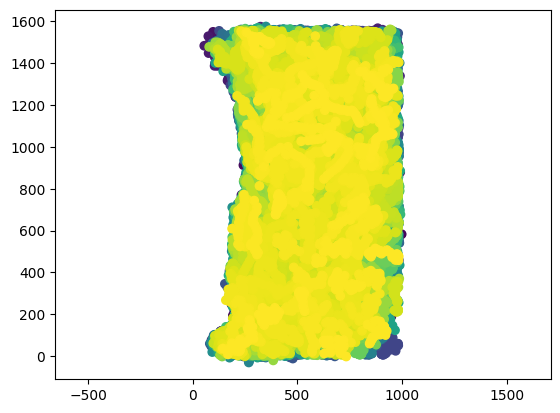

In [7]:
plt.scatter(df_eddies['x0'], df_eddies['y0'], c=df_eddies['ID'])
# plt.plot(df_eddies['x0'], df_eddies['y0'])
plt.axis('equal')

(np.float64(7.359095973834592),
 np.float64(1045.2497596421324),
 np.float64(-110.66291419930491),
 np.float64(1655.999221024783))

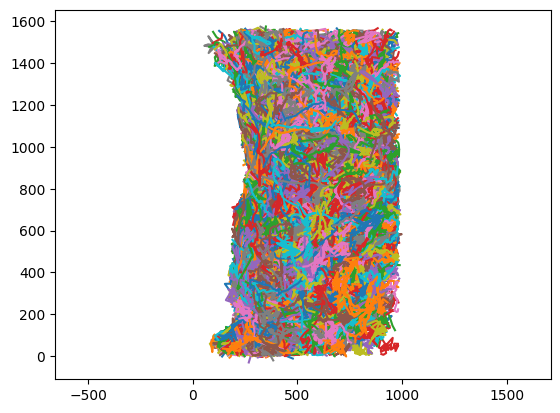

In [8]:
for ID in df_eddies['ID'].unique():
    df = df_eddies[df_eddies['ID']==ID].copy()
    plt.plot(df['x0'], df['y0'])
plt.axis('equal')

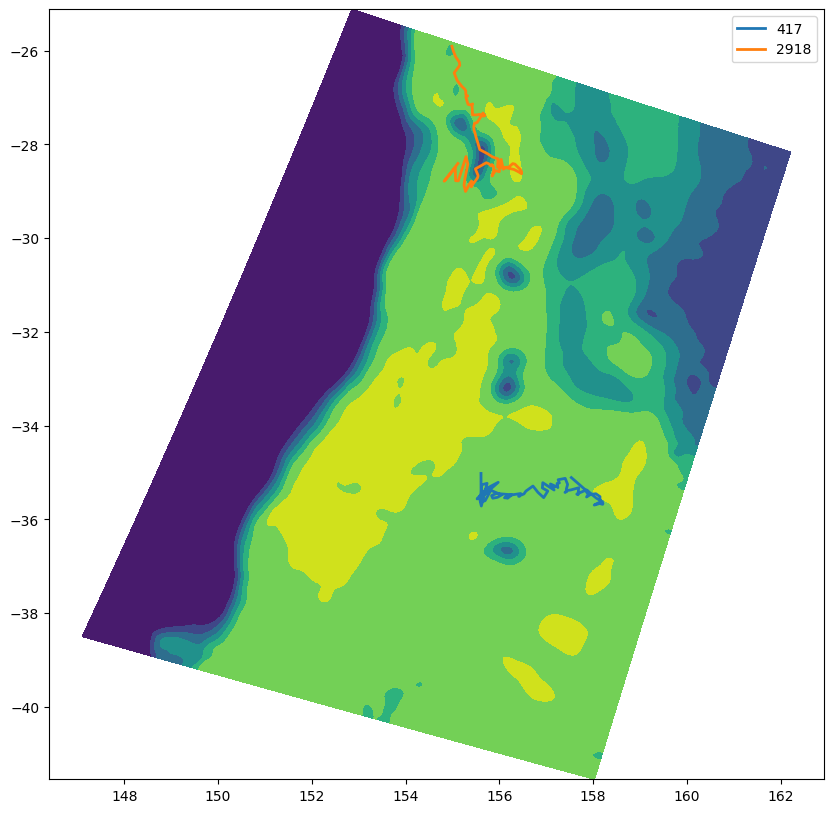

In [9]:
plt.figure(figsize=(10,10))

plt.contourf(lon_rho, lat_rho, h)

for ID in df_eddies['ID'].unique():
    df = df_eddies[df_eddies['ID']==ID].copy()

    # if (df.iloc[0]['Age'] >= 73) and (df.iloc[0]['Age'] <= 78):
    if df.iloc[0]['Age'] == 85:

        if df.iloc[0]['Cyc'] == 'AE':

            # if df.iloc[0]['ID'] == 382:
            plt.plot(df['Lon'], df['Lat'], label=ID, linewidth=2)
        
plt.axis('equal')
plt.legend()


In [10]:
def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    if Q[0,0] < 0:
        Q = -Q

    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):
        return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

In [11]:
id_counts = df_eddies['ID'].value_counts().reset_index()
id_counts.columns = ['ID', 'frequency']
id_counts = id_counts.sort_values('frequency', ascending=False).reset_index(drop=True)
id_counts

,ID,frequency
0,180,436
1,993,388
2,2305,261
3,1737,260
4,925,260
...,...,...
2957,1868,21
2958,266,21
2959,1791,21
2960,1910,21


,Day,ID,Cyc,nLon,nLat,nxc,nyc,nic,njc,Lon,Lat,x0,y0,q11,q12,q22,w,Age,fname
112425,9195,2504,AE,155.289047,-29.149446,374.0,1225.0,374.0,1225.0,155.295944,-29.120408,373.624896,1228.259164,0.004764,0.000400,0.003999,0.017527,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112426,9196,2504,AE,155.366689,-29.231602,384.0,1219.0,384.0,1219.0,155.358689,-29.225019,383.035433,1219.421968,0.005128,0.000555,0.004156,0.018568,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112427,9197,2504,AE,155.421584,-29.172408,387.0,1227.0,387.0,1227.0,155.417290,-29.179152,386.838472,1226.153547,0.004945,0.000724,0.004437,0.018765,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112428,9198,2504,AE,155.450644,-29.152908,389.0,1230.0,389.0,1230.0,155.452489,-29.171777,389.823837,1228.091214,0.004752,0.000621,0.004506,0.018517,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112429,9199,2504,AE,155.392515,-29.191908,385.0,1224.0,385.0,1224.0,155.410462,-29.223687,387.753758,1221.277634,0.004559,0.000609,0.003799,0.016715,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112496,9266,2504,AE,153.914457,-32.342238,360.0,847.0,360.0,847.0,153.926715,-32.344570,361.173212,847.149944,0.007304,0.000663,0.001967,0.018543,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112497,9267,2504,AE,153.904517,-32.367938,360.0,844.0,360.0,844.0,153.913446,-32.370828,360.895416,843.984868,0.007709,0.000241,0.002013,0.019443,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112498,9268,2504,AE,153.881229,-32.399122,359.0,840.0,359.0,840.0,153.884223,-32.416161,359.854182,838.318333,0.008307,-0.000057,0.002044,0.020702,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112499,9269,2504,AE,153.901119,-32.347722,359.0,846.0,359.0,846.0,153.907810,-32.360176,360.025911,844.915418,0.008778,-0.000209,0.001719,0.020993,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


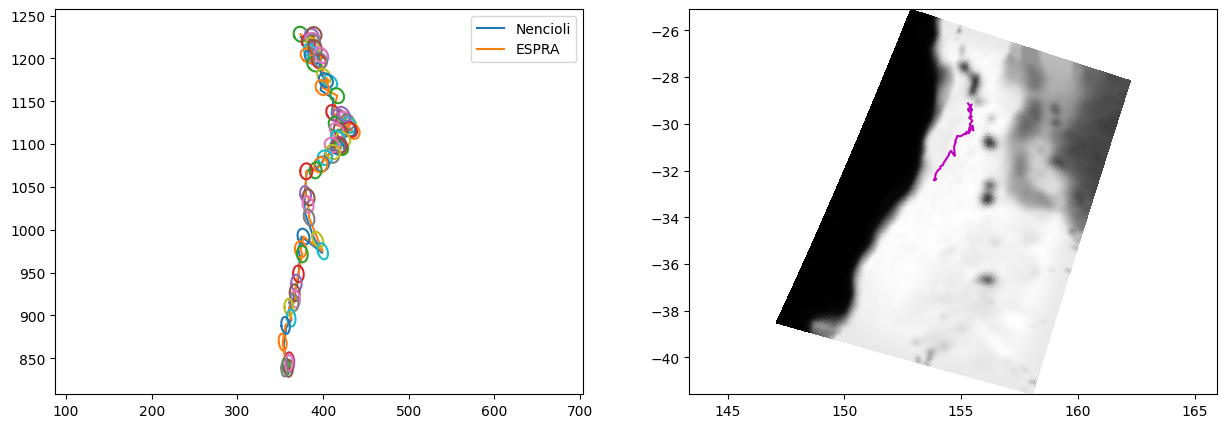

In [12]:
eddy = 2504

fig, axs = plt.subplots(1, 2, figsize=(15,5))

df = df_eddies[df_eddies['ID']==eddy]
axs[0].plot(df['nxc'], df['nyc'], label='Nencioli')
axs[0].plot(df['x0'], df['y0'], label='ESPRA')
axs[1].pcolor(lon_rho, lat_rho, h, cmap='grey')
axs[1].plot(df['Lon'], df['Lat'], 'm')

for x0, y0, q11, q12, q22 in zip(df['x0'], df['y0'], df['q11'], df['q12'], df['q22']):

    Q = np.array([[q11, q12], [q12, q22]])
    x_ell, y_ell = plot_ellipse(Q, center=(x0, y0), scale=10)
    axs[0].plot(x_ell, y_ell)

axs[0].axis('equal')
axs[0].legend()
axs[1].axis('equal')
df


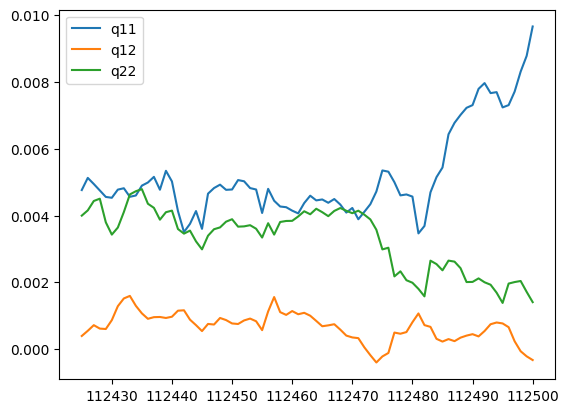

In [13]:
df = df_eddies[df_eddies['ID']==eddy] # 180, 993

plt.plot(df['q11'], label='q11')
plt.plot(df['q12'], label='q12')
plt.plot(df['q22'], label='q22')

# plt.plot(df['w'], label='w')

plt.legend()

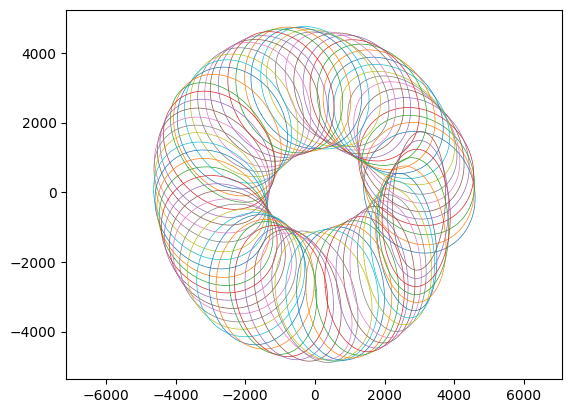

In [14]:
df = df_eddies[df_eddies['ID']==eddy] # 180, 993

# Parameters
n = len(df)
circle_radius = 3000  # radius of the circle
angles = np.linspace(0, 2 * np.pi, n, endpoint=False)

# Plot each ellipse around the circle
for i, (q11, q12, q22, theta) in enumerate(zip(df['q11'], df['q12'], df['q22'], angles)):
    Q = np.array([[q11, q12], [q12, q22]])
    center = (circle_radius * np.cos(theta), circle_radius * np.sin(theta))
    x_ell, y_ell = plot_ellipse(Q, center=center, scale=2000)
    plt.plot(x_ell, y_ell, linewidth=.5)

plt.axis('equal')
plt.show()


### Climatology Peak

In [15]:
def local_velocity_finder(x0, y0, day, fname, X_grid, Y_grid, r=100):

    i, j = np.where(np.hypot(x0 - X_grid, y0 - Y_grid) < r)
    
    dataset = nc.Dataset(fname)

    u_raw = np.transpose(dataset['u_eastward'][:].data, axes=(3, 2, 1, 0))
    v_raw = np.transpose(dataset['v_northward'][:].data, axes=(3, 2, 1, 0))
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
    angle = dataset.variables['angle'][:].data[0,0]

    t = np.where(ocean_time==day)[0][0]
    
    u_raw = u_raw[:, :, :, t].squeeze()[:, :, ::-1]
    v_raw = v_raw[:, :, :, t].squeeze()[:, :, ::-1]

    u_east = np.full_like(u_raw, np.nan, dtype=float)
    v_north = np.full_like(v_raw, np.nan, dtype=float)

    u_east[i, j, :] = u_raw[i, j, :]
    v_north[i, j, :] = v_raw[i, j, :]
    
    u_east = np.where(u_east > 1e30, np.nan, u_east).astype(float)
    v_north = np.where(v_north > 1e30, np.nan, v_north).astype(float)
    
    u_rot = v_north * np.sin(angle) + u_east * np.cos(angle)
    v_rot = v_north * np.cos(angle) - u_east * np.sin(angle)

    return u_rot, v_rot, i, j

(1204.6026077349186, 1596.8359762545194)

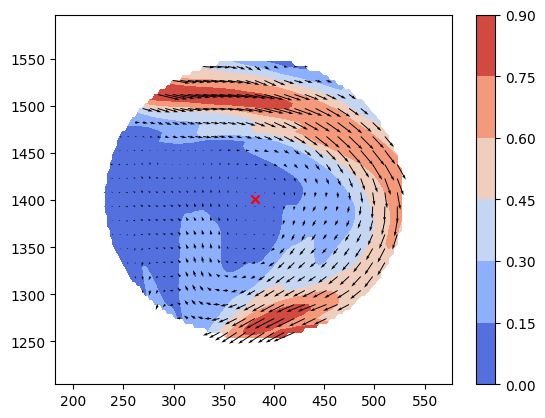

In [16]:
row = df_eddies.iloc[2000]
x0, y0, day, fname = row['x0'], row['y0'], row['Day'], row['fname']

u, v, i, j = local_velocity_finder(x0, y0, day, fname, X_grid, Y_grid, r=150)

depth_lvl = 0

ud, vd = u[:,:,depth_lvl], v[:,:,depth_lvl]

plt.contourf(X_grid, Y_grid, np.hypot(ud, vd), cmap='coolwarm')
plt.colorbar()
plt.scatter(x0, y0, marker='x', color='r')
spacing = 3
plt.quiver(X_grid[::spacing, ::spacing], Y_grid[::spacing, ::spacing], ud[::spacing, ::spacing], vd[::spacing, ::spacing], scale=15)

i_mask, j_mask = np.where(~np.isnan(ud))

plt.xlim(x_grid[np.min(i_mask)]-50, x_grid[np.max(i_mask)]+50)
plt.ylim(y_grid[np.min(j_mask)]-50, y_grid[np.max(j_mask)]+50)

In [17]:
def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.array([[np.nan, np.nan], [np.nan, np.nan]]), np.nan
    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])
    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 
    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    Q = np.array([[q11, q12], [q12, q22]])
    return x0, y0, Q, w


In [120]:
def depth_profiler(eddy, day, df_eddies, X_grid, Y_grid, r=200):
    
    row = df_eddies[(df_eddies['ID']==eddy) & (df_eddies['Day']==day)]

    x0, y0, fname = row.iloc[0]['x0'], row.iloc[0]['y0'], row.iloc[0]['fname']
    fnumber = fname[-8:-3]
    
    i, j = np.where(np.hypot(x0 - X_grid, y0 - Y_grid) <= r)

    u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
    v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
    
    dataset = nc.Dataset(fname)
    ocean_time = dataset.variables['ocean_time'][:].data / 86400

    t = np.where(ocean_time==day)[0][0]
    
    u = u_raw[i, j, :, t].squeeze()
    v = v_raw[i, j, :, t].squeeze()

    u = np.where(u > 1e30, np.nan, u).astype(float)
    v = np.where(v > 1e30, np.nan, v).astype(float)

    x, y = X_grid[i, j], Y_grid[i, j]

    return u, v, x, y
    

In [127]:
# df_eddies[(df_eddies['ID']==eddy)]


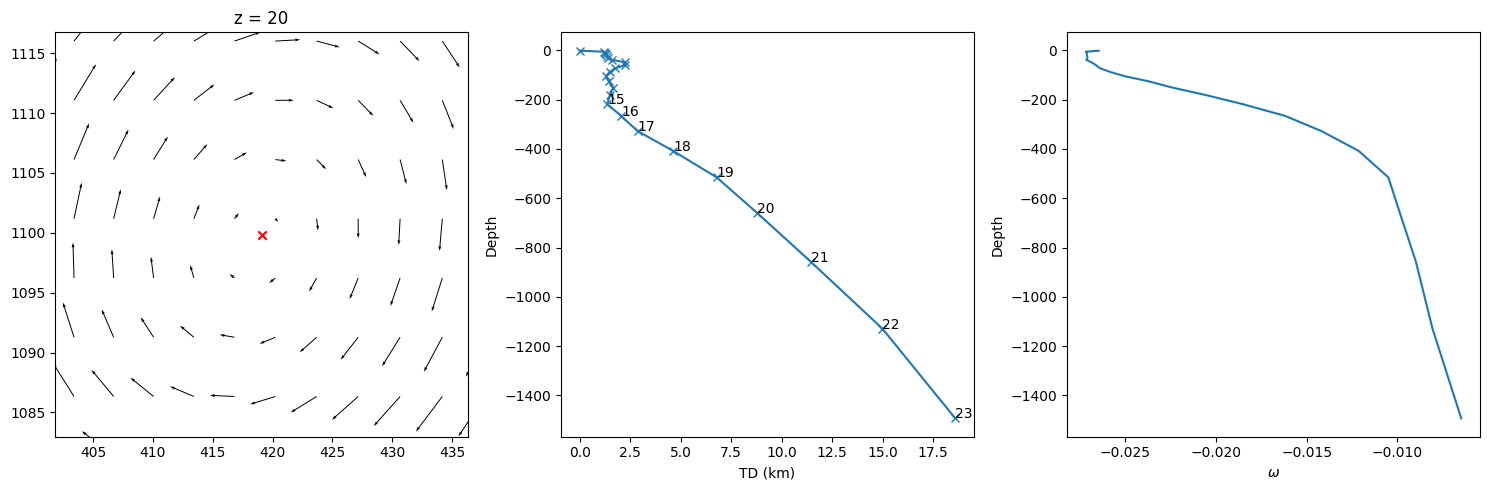

In [130]:
eddy = 1967
day = 7595

u, v, x, y = depth_profiler(eddy, day, df_eddies, X_grid, Y_grid)

df = pd.DataFrame(columns=['x0', 'y0', 'Q', 'w', 'z', 'Depth'])

row = df_eddies[(df_eddies['ID']==eddy) & (df_eddies['Day']==day)]
x0, y0 = row.iloc[0]['x0'], row.iloc[0]['y0']

for k in range(24):

    mask = np.hypot(x-x0, y-y0) <= 15
    ui, vi, xi, yi = u[mask, k], v[mask, k], x[mask], y[mask] 

    x0_old, y0_old = x0, y0
    x0, y0, Q, w = espra(xi, yi, ui, vi)
    if (np.sign(w) == np.sign(row.iloc[0]['w'])) and (np.hypot(x0-x0_old, y0-y0_old) < 50):
        df.loc[len(df)] = {'x0': x0, 'y0': y0, 'Q': Q, 'w': w, 'z': k, 'Depth': z_r[150,150,k]}

    else:
        x0, y0 = x0_old, y0_old
    
df = df.set_index('z')


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

z = 20

axs[0].quiver(x, y, u[:,z], v[:,z], scale=1)
axs[0].scatter(df.loc[z]['x0'], df.loc[z]['y0'], marker='x', color='r')
axs[0].axis('equal')
axs[0].set_title(f"z = {z}")

axs[0].set_xlim(df.loc[z]['x0']-15, df.loc[z]['x0'] +15)
axs[0].set_ylim(df.loc[z]['y0']-15, df.loc[z]['y0'] +15)

df['x0'] = df['x0'] - df.iloc[0]['x0']
df['y0'] = df['y0'] - df.iloc[0]['y0']
df['TD'] = np.hypot(df['x0'], df['y0'])

axs[1].plot(df['TD'], df['Depth'], marker='x')
for (TD, d, z) in zip(df['TD'], df['Depth'], df.index):
    if z >= 15:
        axs[1].text(TD, d, f"{z}")

axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth')

axs[2].plot(df['w'], df['Depth'])
axs[2].set_xlabel(r'$\omega$')
axs[2].set_ylabel('Depth')

plt.tight_layout()
plt.show()


In [128]:
df.head()


,x0,y0,Q,w,Depth,TD
z,,,,,,
0,0.000000,0.000000,"[[-0.005895088861205603, -0.001024209790112471...",-0.027545,-1.783320,0.000000
1,-2.070070,-0.055446,"[[-0.006607131653627049, -0.001175391964916452...",-0.029468,-5.879627,2.070813
2,-3.307155,-0.091158,"[[-0.006217993892349452, -0.001147657299544476...",-0.028577,-10.725783,3.308411
3,-3.970767,-0.078227,"[[-0.0058481968887435344, -0.00112462922195327...",-0.027305,-16.383097,3.971537
4,-4.393454,-0.296310,"[[-0.005795170725946105, -0.001179054000917696...",-0.027063,-22.925581,4.403435


(np.float64(-2.162710828264336),
 np.float64(24.769668896295258),
 np.float64(-1.0607260625487063),
 np.float64(1.0610021967033918))

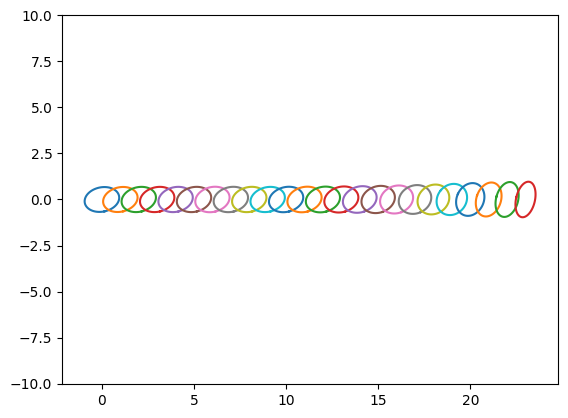

In [131]:

for i, (d, Q) in enumerate(zip(df['Depth'], df['Q'])):
    x_ell, y_ell = plot_ellipse(Q, center=(i, 0))
    plt.plot(x_ell, y_ell)

plt.axis('equal')

#### Stitching Test

In [21]:
df_R = pd.read_pickle(f"/srv/scratch/z5297792/Chapter2/df_R_1462_10650.pkl")
df_R


,D_diff,W_diff,R
0,484.120799,0.009590,484.122224
1,166.296518,0.020998,166.316402
2,611.995756,0.017877,611.999673
3,267.279684,0.036657,267.317388
4,487.741348,0.012128,487.743610
...,...,...,...
60363036,148.683071,0.014950,148.694345
60363037,71.737251,0.004174,71.739072
60363038,152.230999,0.015239,152.242440
60363039,485.198530,0.004232,485.198807


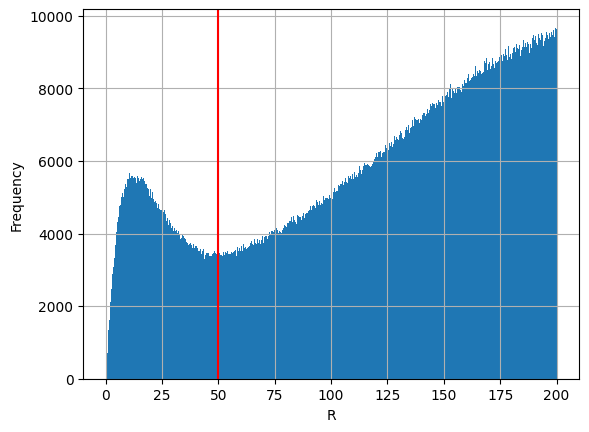

In [22]:
df_R[df_R['R']<=200]['R'].hist(bins=1000) # NEED TO MAKE IT 50 !!!!!!
plt.axvline(x=50, color='r') 
plt.xlabel('R')
plt.ylabel('Frequency')
# plt.xlim(0, 100)
plt.show()

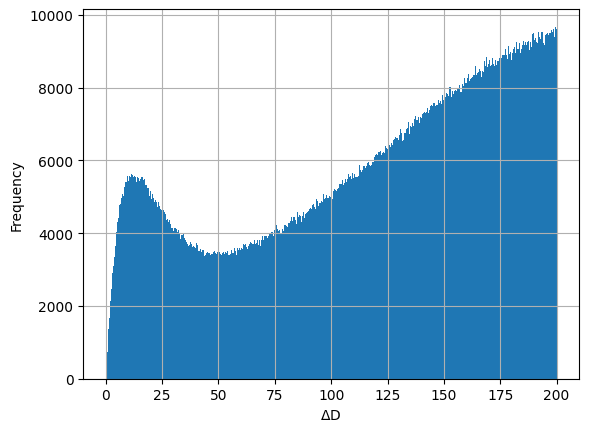

In [23]:
df_R[df_R['D_diff']<=200]['D_diff'].hist(bins=1000)
# plt.axvline(x=30, color='r')
plt.xlabel(r'$\Delta$D')
plt.ylabel('Frequency')
# plt.xlim(0, 100)
plt.show()

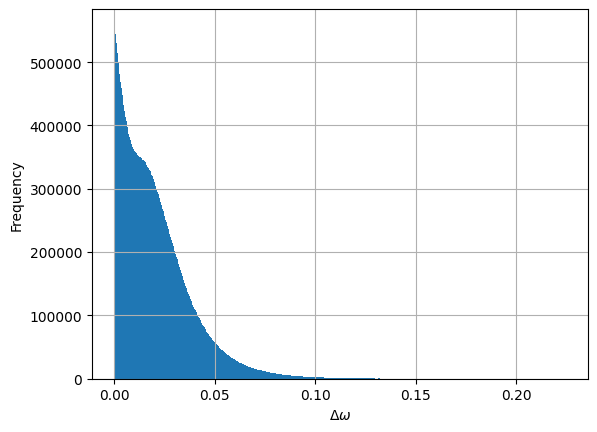

In [24]:
df_R['W_diff'].hist(bins=1000)
# plt.axvline(x=30, color='r')
plt.xlabel(r'$\Delta\omega$')
plt.ylabel('Frequency')
# plt.xlim(0, 100)
plt.show()